# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Complex Analytics using Pyspark

## Problem Statement

Perform complex analytics on a network intrusion dataset using Pyspark

## Learning Objectives

At the end of the mini-project, you will be able to :

* analyze the data using Pyspark
* implement RDD based operations on the data
* derive insights from the complex data

### Dataset

The dataset chosen for this mini-project is a [10% subset](https://www.kdd.org/kdd-cup/view/kdd-cup-1999/Data) of the **[KDD Cup 1999 dataset](http://kdd.ics.uci.edu/databases/kddcup99/task.html)** (Computer network intrusion detection). This is the dataset used for the Third International Knowledge Discovery and Data Mining Tools Competition. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between ``bad`` connections, called intrusions or attacks, and ``good`` normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

## Information

Since 1999, KDD’99 has been the most widely used data set for the evaluation of anomaly detection methods. This data set is prepared by S. J. Stolfo and is built based on the data captured in DARPA’98 IDS evaluation program. DARPA’98 is about 4 gigabytes of compressed raw (binary) tcpdump data of 7 weeks of network traffic, which can be processed into about 5 million connection
records, each with about 100 bytes. KDD dataset consists of approximately 4,900,000 single connection vectors each of which contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The simulated attacks fall into one of the following four categories:

* Denial of Service Attack (DoS): making some computing or memory resources too busy so that they deny legitimate users access to these resources.
* User to Root Attack (U2R): unauthorized access from a remote machine according to exploit machine's vulnerabilities.
* Remote to Local Attack (R2L): unauthorized access to local super user (root) privileges using system's susceptibility.
* Probing Attack: host and port scans as precursors to other attacks. An attacker scans a network to gather information or find known vulnerabilities.

KDD’99 features can be classified into three groups:

1) Basic features: this category encapsulates all the attributes that can be extracted from a TCP/IP connection. Most of these features leading to an implicit delay in detection.

2) Traffic features: this category includes features that are computed with respect to a window interval and is divided into two groups:

  * "same host" features

  * "same service" features

3) Content features: unlike most of the DoS and Probing attacks, the R2L and U2R attacks don’t have any intrusion frequent sequential patterns. This is because the DoS and Probing attacks involve many connections to some host(s) in a very short period of time, however the R2L and U2R attacks are embedded in the data portions of the packets, and normally involve only a single connection. To detect these kinds of attacks, we need some features to be able to look for suspicious behavior in the data portion, e.g., the number of failed login attempts. These features are called content features.

## Grading = 10 Points

In [1]:
#@title Install packages and Download Dataset
!pip -qq install pyspark
# Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/kddcup.data_10_percent.gz
# Download feature names
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/kddcup.names
print("Successfully Installed packages and downloaded datasets!")

Successfully Installed packages and downloaded datasets!


### Create Spark Session and load the data (1 point)

#### Import required packages

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from operator import add

#### Create a Spark session

A Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0 (Instead of having various contexts, everything is encapsulated in a Spark session)

In [3]:
# Start spark session
# YOUR CODE HERE
spark = SparkSession.builder \
    .appName("KDDCup99_Network_Intrusion_Analysis") \
    .getOrCreate()


#### Creating an RDD from a File

The most common way of creating an RDD is to load it from a file. Notice that Spark's textFile can handle compressed files directly.

In [4]:
# YOUR CODE HERE to access sparkContext from sparkSession instance.
sc = spark.sparkContext
filePath = "kddcup.data_10_percent.gz"
network_rdd = sc.textFile(filePath)
network_rdd.take(10)  # Show top 10 lines to verify loading


['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,59,59,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.00,0.00,0.00,0.00,1.00,0.00,

Load the dataset and show the top 10 records

Hint: sparkContext.textFile()

In [ ]:
filePath = "/content/kddcup.data_10_percent.gz"
# YOUR CODE HERE

### RDD Basic Operations (4 points)

#### Convert the data to CSV format (list of elements).

To create a Dataframe using the RDD file, convert each row into a list by splitting with a comma (,)

Hint: `map()` and `split()`

In [5]:
# YOUR CODE HERE
network_csv_rdd = network_rdd.map(lambda line: line.split(","))
network_csv_rdd.take(5)


[['0',
  'tcp',
  'http',
  'SF',
  '181',
  '5450',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '8',
  '8',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '9',
  '9',
  '1.00',
  '0.00',
  '0.11',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  'normal.'],
 ['0',
  'tcp',
  'http',
  'SF',
  '239',
  '486',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '8',
  '8',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '19',
  '19',
  '1.00',
  '0.00',
  '0.05',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  'normal.'],
 ['0',
  'tcp',
  'http',
  'SF',
  '235',
  '1337',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '8',
  '8',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '29',
  '29',
  '1.00',
  '0.00',


Count how many interactions are normal and attacked in the dataset.

Hint: apply `filter` on each row, except the rows with 'normal.', all the remaining values are attacked.

In [6]:
# YOUR CODE HERE
normal_rdd = network_csv_rdd.filter(lambda x: x[-1] == "normal.")
attack_rdd = network_csv_rdd.filter(lambda x: x[-1] != "normal.")
normal_count = normal_rdd.count()
attack_count = attack_rdd.count()
(normal_count, attack_count)


(97278, 396743)

#### Protocol and Service combinations using Cartesian product

We can compute the Cartesian product between two RDDs by using the Cartesian transformation. It returns all possible pairs of elements between two RDDs. In our case, we will use it to generate all the possible combinations between Service and Protocol in our network interactions.

First of all, isolate each collection of values in two separate RDDs. For that use `distinct` on the CSV-parsed dataset. From the dataset description, we know that protocol is the second column and service is the third.

In [9]:
# YOUR CODE HERE
protocol_rdd = network_csv_rdd.map(lambda x: x[1]).distinct()
service_rdd = network_csv_rdd.map(lambda x: x[2]).distinct()

Now let's do the Cartesian product

Hint: [Cartesian](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.cartesian.html#:~:text=Return%20the%20Cartesian%20product%20of,and%20b%20is%20in%20other%20.)

In [10]:
# YOUR CODE HERE
cartesian_product_rdd = protocol_rdd.cartesian(service_rdd)
cartesian_product_rdd.take(5)

[('tcp', 'http'),
 ('tcp', 'smtp'),
 ('tcp', 'finger'),
 ('tcp', 'domain_u'),
 ('tcp', 'auth')]

#### Inspecting interaction duration

select the total duration of interactions for normal and attack intrusion types.
* Use the above filtered normal and attacked data and convert the duration column to integer type using `map()`
* get the sum of duration by applying `reduce` on both the data using add operator
* find the mean of duration by dividing the sum with count

Hint: [reduce()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduce.html)

In [11]:
# YOUR CODE HERE
normal_duration_rdd = normal_rdd.map(lambda x: int(x[0]))
attack_duration_rdd = attack_rdd.map(lambda x: int(x[0]))

normal_total_duration = normal_duration_rdd.reduce(add)
attack_total_duration = attack_duration_rdd.reduce(add)

normal_mean_duration = normal_total_duration / normal_count
attack_mean_duration = attack_total_duration / attack_count

(normal_total_duration, normal_mean_duration, attack_total_duration, attack_mean_duration)


(21075991, 216.65732231336992, 2626792, 6.620890601724542)

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

#### Data aggregation with key/value pair RDDs

We can use all the transformations and actions available for normal RDDs with key/value pair RDDs. We just need to make the functions work with pair elements.

* create a key/value pair of intrusion type and duration
* calculate the total duration of each intrusion type using `reduceByKey()`

In [12]:
# YOUR CODE HERE
intrusion_duration_rdd = network_csv_rdd.map(lambda x: (x[-1], int(x[0])))
duration_per_intrusion_rdd = intrusion_duration_rdd.reduceByKey(add)
duration_per_intrusion_rdd.collect()


[('normal.', 21075991),
 ('buffer_overflow.', 2751),
 ('loadmodule.', 326),
 ('perl.', 124),
 ('neptune.', 0),
 ('smurf.', 0),
 ('guess_passwd.', 144),
 ('pod.', 0),
 ('teardrop.', 0),
 ('portsweep.', 1991911),
 ('ipsweep.', 43),
 ('land.', 0),
 ('ftp_write.', 259),
 ('back.', 284),
 ('imap.', 72),
 ('satan.', 64),
 ('phf.', 18),
 ('nmap.', 0),
 ('multihop.', 1288),
 ('warezmaster.', 301),
 ('warezclient.', 627563),
 ('spy.', 636),
 ('rootkit.', 1008)]

### Create a DataFrame with the header as features (2 points)

* Read the features (*kddcup.names*) and preprocess.

    Hints:
    - Each feature description appears row-wise in *kddcup.names*
    - The first row consists of distinct values of intrusion_types
    - Add or move the *intrusion_types* column name to the last, to align with the data.
    - Each feature is represented as *feature_name*: *type*, remove *type* after colon (:)

In [13]:
# YOUR CODE HERE
feature_file_path = "kddcup.names"
feature_names = []

with open(feature_file_path, 'r') as f:
    for line in f:
        if ':' in line and not line.startswith('|'):
            feature = line.split(':')[0]
            feature_names.append(feature.strip())

# Add the label column at the end
feature_names.append('intrusion_type')

print(feature_names[:5])  # Sample output of first 5 feature names


['duration', 'protocol_type', 'service', 'flag', 'src_bytes']


* Create a dataframe with the data and headers as preprocessed feature names

In [14]:
# YOUR CODE HERE
df = spark.createDataFrame(network_csv_rdd, schema=feature_names)
df.show(5)


+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+--------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|

#### What is the count of each protocol type?

Hint: apply `groupby` on protocol_type and count the records

In [15]:
# YOUR CODE HERE
df.groupBy("protocol_type").count().show()


+-------------+------+
|protocol_type| count|
+-------------+------+
|          tcp|190065|
|          udp| 20354|
|         icmp|283602|
+-------------+------+



#### Register the DataFrame as a temporary table and extract the data using queries

Hint: [registerTempTable](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.registerTempTable.html)

In [16]:
# YOUR CODE HERE
df.createOrReplaceTempView("network_data")

* query to extract the label and their frequencies

 Hint: `SQLContext.sql(query)`

In [17]:
# YOUR CODE HERE
# Query label frequencies
spark.sql("SELECT intrusion_type, COUNT(*) AS frequency FROM network_data GROUP BY intrusion_type ORDER BY frequency DESC").show()

+----------------+---------+
|  intrusion_type|frequency|
+----------------+---------+
|          smurf.|   280790|
|        neptune.|   107201|
|         normal.|    97278|
|           back.|     2203|
|          satan.|     1589|
|        ipsweep.|     1247|
|      portsweep.|     1040|
|    warezclient.|     1020|
|       teardrop.|      979|
|            pod.|      264|
|           nmap.|      231|
|   guess_passwd.|       53|
|buffer_overflow.|       30|
|           land.|       21|
|    warezmaster.|       20|
|           imap.|       12|
|        rootkit.|       10|
|     loadmodule.|        9|
|      ftp_write.|        8|
|       multihop.|        7|
+----------------+---------+
only showing top 20 rows



* select the distinct protocol types with their count of transactions which are not normal

In [18]:
# YOUR CODE HERE
spark.sql("""
    SELECT protocol_type, COUNT(*) as cnt
    FROM network_data
    WHERE intrusion_type != 'normal.'
    GROUP BY protocol_type
""").show()


+-------------+------+
|protocol_type|   cnt|
+-------------+------+
|          tcp|113252|
|          udp|  1177|
|         icmp|282314|
+-------------+------+



* select count of transactions in each protocol type that lasts more than 1 second (duration > 1000), with no data transfer from destination (dst_bytes == 0)

In [19]:
# YOUR CODE HERE
spark.sql("""
    SELECT protocol_type, COUNT(*) as cnt
    FROM network_data
    WHERE duration > 1000 AND dst_bytes == 0
    GROUP BY protocol_type
""").show()


+-------------+---+
|protocol_type|cnt|
+-------------+---+
|          tcp|139|
+-------------+---+



### Find the highly correlated columns (2 points)

* identify the columns which are not integer type and remove those columns
* apply correlation function on the data (Hint: `Statistics.corr()`)
* collect the names of the columns on which correlation is applied
* create a dataframe with correlation matrix with index and columns as names
* get the highly correlated features by considering a correlation value greater than 0.8

    Hint: `np.triu()` , `pd.mask()`

In [24]:
# YOUR CODE HERE
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np

# Step 1: Define non-numeric columns
non_numeric_cols = ['protocol_type', 'service', 'flag', 'intrusion_type']

# Step 2: Cast numeric columns to float
numeric_cols = [c for c in df.columns if c not in non_numeric_cols]
for col_name in numeric_cols:
    df = df.withColumn(col_name, df[col_name].cast(FloatType()))

# Step 3: Assemble columns into feature vector
vector_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
vector_df = vector_assembler.transform(df).select("features")

# Step 4: Correlation matrix using pyspark.ml.stat.Correlation
# Calculate the correlation matrix
corr_matrix = Correlation.corr(vector_df, "features").head()[0].toArray()

# Step 5: Create pandas dataframe
corr_df = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)

# Step 6: Identify highly correlated features (> 0.8)
# Use numpy to get the upper triangle (excluding diagonal) and unravel it
upper_tri_unstacked = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool)).stack()



In [27]:
# Filter for correlations with absolute value > 0.8
high_corr_pairs = upper_tri_unstacked[upper_tri_unstacked.abs() > 0.8].sort_values(ascending=False)


print("Highly correlated feature pairs (absolute correlation > 0.8):")
for (col1, col2), value in high_corr_pairs.items():
    print(f"('{col1}', '{col2}', {value})")

Highly correlated feature pairs (absolute correlation > 0.8):
('srv_serror_rate', 'dst_host_srv_serror_rate', 0.9993041091830381)
('serror_rate', 'dst_host_serror_rate', 0.9986729680056983)
('serror_rate', 'srv_serror_rate', 0.9983615072759132)
('dst_host_serror_rate', 'dst_host_srv_serror_rate', 0.9981559173386606)
('serror_rate', 'dst_host_srv_serror_rate', 0.9978492485687793)
('srv_serror_rate', 'dst_host_serror_rate', 0.9978353003732233)
('rerror_rate', 'srv_rerror_rate', 0.9947309539363997)
('num_compromised', 'num_root', 0.993827797885562)
('rerror_rate', 'dst_host_rerror_rate', 0.9869947925192707)
('srv_rerror_rate', 'dst_host_srv_rerror_rate', 0.9865705438345939)
('rerror_rate', 'dst_host_srv_rerror_rate', 0.9851995540542458)
('dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 0.9848038371643612)
('srv_rerror_rate', 'dst_host_rerror_rate', 0.9821663427469293)
('dst_host_srv_count', 'dst_host_same_srv_rate', 0.9736854572721076)
('srv_count', 'dst_host_same_src_port_rate', 0.944

In [ ]:
# eliminating names of columns having string type
# YOUR CODE HERE

In [ ]:
# creating a dataframe with correlation matrix
# YOUR CODE HERE

In [28]:
#  fill the null values with 0
# YOUR CODE HERE
corr_df.fillna(0, inplace=True)


In [29]:
# Finding features with correlation value more than specified threshold value (bar=0.9)
# YOUR CODE HERE
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

high_corr_pairs = []
threshold = 0.9

for col in upper_tri.columns:
    for row in upper_tri.index:
        corr_value = upper_tri.loc[row, col]
        if pd.notnull(corr_value) and corr_value > threshold:
            high_corr_pairs.append((row, col, corr_value))

# Optional: sort the pairs by correlation value descending
high_corr_pairs = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)

# Display the high correlation pairs
for pair in high_corr_pairs:
    print(f"Features: {pair[0]} & {pair[1]} - Correlation: {pair[2]:.3f}")


Features: srv_serror_rate & dst_host_srv_serror_rate - Correlation: 0.999
Features: serror_rate & dst_host_serror_rate - Correlation: 0.999
Features: serror_rate & srv_serror_rate - Correlation: 0.998
Features: dst_host_serror_rate & dst_host_srv_serror_rate - Correlation: 0.998
Features: serror_rate & dst_host_srv_serror_rate - Correlation: 0.998
Features: srv_serror_rate & dst_host_serror_rate - Correlation: 0.998
Features: rerror_rate & srv_rerror_rate - Correlation: 0.995
Features: num_compromised & num_root - Correlation: 0.994
Features: rerror_rate & dst_host_rerror_rate - Correlation: 0.987
Features: srv_rerror_rate & dst_host_srv_rerror_rate - Correlation: 0.987
Features: rerror_rate & dst_host_srv_rerror_rate - Correlation: 0.985
Features: dst_host_rerror_rate & dst_host_srv_rerror_rate - Correlation: 0.985
Features: srv_rerror_rate & dst_host_rerror_rate - Correlation: 0.982
Features: dst_host_srv_count & dst_host_same_srv_rate - Correlation: 0.974
Features: srv_count & dst_h

### Analysis report (1 points)

* Find the ratio of attacked transactions vs normal transactions

    Hint: encode instrusion_type column by replacing normal with 1 and all other with 0

* Describe the statistics of attacked and normal transactions
    
    Hint: Min, Max, Mean
    
* Select any two features that influence the intrusion_type and visualize the scatter plot to see the separation of normal and attacked

In [30]:
# YOUR CODE HERE
from pyspark.sql.functions import when, col

# Encode intrusion_type: normal -> 1, attack -> 0
df_encoded = df.withColumn("label", when(col("intrusion_type") == "normal.", 1).otherwise(0))

# Count normal and attack transactions
counts = df_encoded.groupBy("label").count().collect()

count_normal = next(row["count"] for row in counts if row["label"] == 1)
count_attack = next(row["count"] for row in counts if row["label"] == 0)

ratio_attack_normal = count_attack / count_normal
print(f"Normal count: {count_normal}, Attack count: {count_attack}")
print(f"Ratio (Attack/Normal): {ratio_attack_normal:.3f}")


Normal count: 97278, Attack count: 396743
Ratio (Attack/Normal): 4.078


In [31]:
# YOUR CODE HERE
# Features to describe statistics for
features_to_describe = ["duration", "src_bytes"]

# Summary statistics for normal (label=1)
normal_stats = df_encoded.filter(col("label") == 1).select(features_to_describe).describe()
normal_stats.show()

# Summary statistics for attack (label=0)
attack_stats = df_encoded.filter(col("label") == 0).select(features_to_describe).describe()
attack_stats.show()


+-------+------------------+------------------+
|summary|          duration|         src_bytes|
+-------+------------------+------------------+
|  count|             97278|             97278|
|   mean|216.65732231336992| 1157.047523592179|
| stddev|1359.2134689176582|34226.124718051324|
|    min|               0.0|               0.0|
|    max|           58329.0|         2194619.0|
+-------+------------------+------------------+

+-------+------------------+------------------+
|summary|          duration|         src_bytes|
+-------+------------------+------------------+
|  count|            396743|            396743|
|   mean| 6.620890601724542|3483.7658912696634|
| stddev|402.56428773645115|1102603.7874645572|
|    min|               0.0|               0.0|
|    max|           42448.0|       6.9337562E8|
+-------+------------------+------------------+



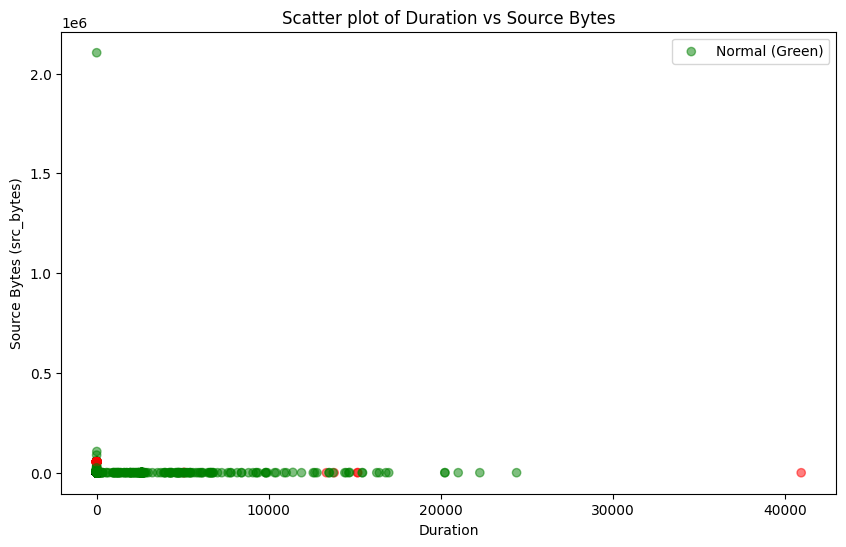

In [32]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

# Select features and label
plot_columns = ["duration", "src_bytes", "label"]

# Collect sample to Pandas for plotting
pdf = df_encoded.select(plot_columns).sample(fraction=0.05, seed=42).toPandas()

# Scatter plot
plt.figure(figsize=(10,6))
colors = {1: "green", 0: "red"}

plt.scatter(pdf["duration"], pdf["src_bytes"], c=pdf["label"].map(colors), alpha=0.5, label=None)
plt.xlabel("Duration")
plt.ylabel("Source Bytes (src_bytes)")
plt.title("Scatter plot of Duration vs Source Bytes")
plt.legend(["Normal (Green)", "Attack (Red)"])
plt.show()
